# Lead-Acid Models

We compare a standard porous-electrode model for lead-acid batteries with two asymptotic reductions. For a more in-depth introduction to PyBaMM models, see the [SPM notebook](./SPM.ipynb).

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

### "Full" model

Bla bla 

This model is implemented in PyBaMM as the `NewmanTiedemann` model 

In [2]:
full = pybamm.lead_acid.NewmanTiedemann()

### "Leading-order" model 

Bla bla

This model is implemented in PyBaMM as `LOQS` (leading-order quasi-static)

In [3]:
loqs = pybamm.lead_acid.LOQS()

### "Composite" model

Bla bla 

This model is implemented in PyBaMM as `Composite`

In [4]:
composite = pybamm.lead_acid.Composite()

## Solving the models

We load process parameters for each model, using the same set of (default) parameters for all

In [5]:
# load models
models = [loqs, composite, full]

# process parameters
param = models[0].default_parameter_values
for model in models:
    param.process_model(model)

Then, we discretise the models, using the default settings

In [6]:
discs = {}
for model in models:
    # load and process default geometry
    geometry = model.default_geometry
    param.process_geometry(geometry)
    
    # discretise using default settings
    mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
    disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
    disc.process_model(model)
    discs[model] = disc

Finally, we solve each model using its own individual solver

In [7]:
timer = pybamm.Timer()
solvers = {}
t_eval = np.linspace(0, 1, 100)
for model in models:
    solver = model.default_solver
    start = timer.time()
    solver.solve(model, t_eval)
    end = timer.time()
    print("Solved the {} in {:.3f} seconds".format(model.name, end-start))
    solvers[model] = solver

Solved the LOQS model in 0.037 seconds
Solved the Composite model in 0.260 seconds
Solved the Newman-Tiedemann model in 13.150 seconds


## Results

To plot the results, we create `ProcessedVariable` objects, which can be evaluated at any time and position. For example, we can compare the voltages:

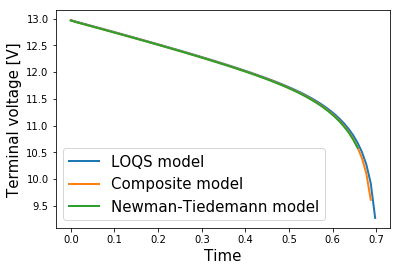

In [19]:
for model in models:
    t, y = solvers[model].t, solvers[model].y
    voltage = pybamm.ProcessedVariable(model.variables["Terminal voltage [V]"], t, y)
    plt.plot(t, voltage(t) * 6, lw=2, label=model.name)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Alternatively, using `QuickPlot`, we can compare the values of some variables

In [28]:
mesh = list(discs.values())[0].mesh
quick_plot = pybamm.QuickPlot(models, mesh, list(solvers.values()))
import ipywidgets as widgets
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.696969696969697, step=0.05), Output()), _d…

If we update the current, setting it to be 20 A, we observe a greater discrepancy between the full model and the reduced-order models.

In [30]:
# update parameter values and solve again
param.update({"Typical current density": 20})
for model in models:
    param.update_model(model, discs[model])
    solvers[model].solve(model, t_eval)

# Plot
quick_plot = pybamm.QuickPlot(models, mesh, list(solvers.values()))
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.696969696969697, step=0.05), Output()), _d…